## Import Essential Libraries

We start by importing essential Python libraries such as `os` for operating system dependent functionalities and `pandas` for data manipulation.


In [1]:
import os
import pandas as pd

## Initialize PySpark Configuration

Here, we initialize the Spark Configuration and Context. This is a necessary step before performing any Spark operations.


In [2]:
from pyspark import SparkConf, SparkContext

# Initialize SparkConf and SparkContext
conf = SparkConf().setAppName("YourAppName").setMaster("local[*]")  # Adjust the parameters as needed
sc = SparkContext(conf=conf)

# Set log level
sc.setLogLevel("ERROR")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/28 10:47:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Import PySpark and Initialize

In this cell, we import the PySpark library and initialize the Spark Session.


In [3]:
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

# sc = pyspark.SparkContext(appName="imbalanced_binary_classification")
# initiate our session and read the main CSV file, then we print the #dataframe schema
spark = SparkSession.builder.appName('imbalanced_binary_classification').getOrCreate()
  

new_df = spark.read.csv('application_train.csv', header=True, inferSchema=True)
new_df.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

## Data Preprocessing: Dropping Columns

In this section, we drop columns that are not needed for our analysis. Here, we drop the 'SK_ID_CURR' column.


In [4]:
drop_col = ['SK_ID_CURR']
new_df = new_df.select([column for column in new_df.columns if column not in drop_col])
new_df = new_df.withColumnRenamed('TARGET', 'label')
new_df.groupby('label').count().toPandas()

,label,count
0,1,24825
1,0,282686


## Exploring Target Distribution

We visualize the distribution of our target variable to understand the class imbalance, if any.


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


307511


<AxesSubplot: xlabel='label', ylabel='count'>

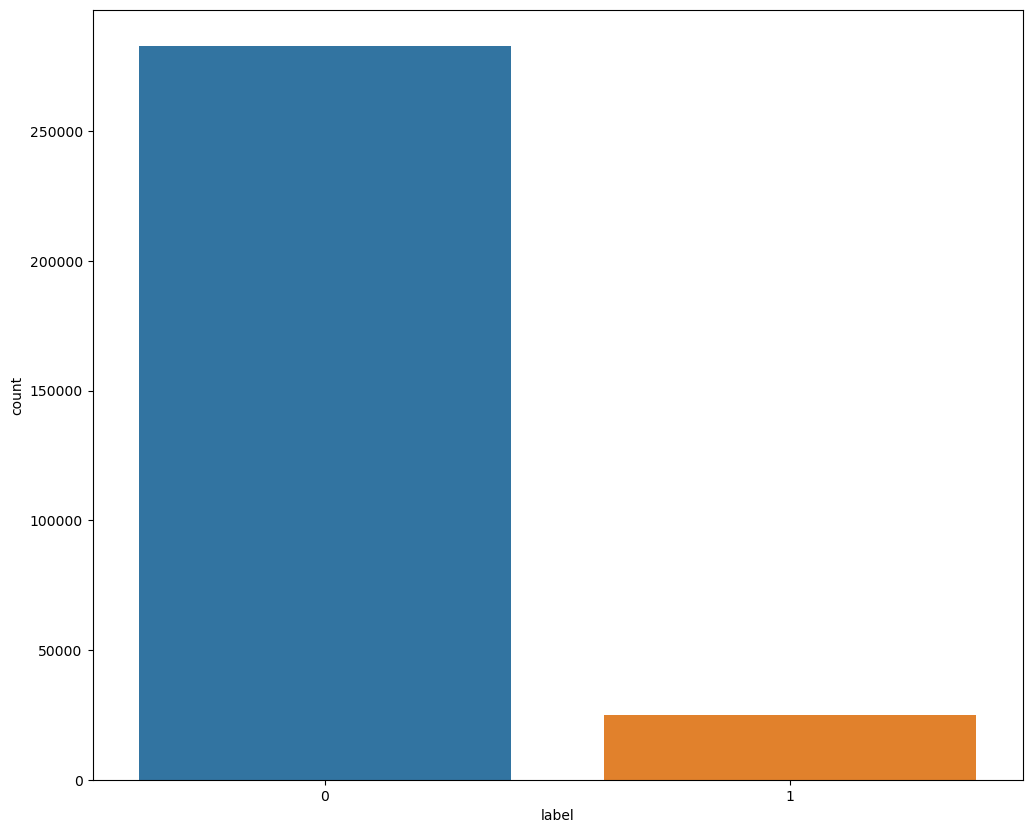

In [5]:
# let's have a look at the distribution of our target variable:
# to make it look better, we first convert our spark df to a Pandas
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_pd = new_df.toPandas()
print(len(df_pd))
plt.figure(figsize=(12,10))
sns.countplot(x='label', data=df_pd, order=df_pd['label'].value_counts().index)


## Data Overview with Pandas

We take a look at the data using Pandas for a quick exploration. This helps in understanding the data before diving deeper into analysis.


In [2]:
# let's see how everything look in Pandas
import pandas as pd
pd.DataFrame(new_df.take(10), columns= new_df.columns)


NameError: name 'new_df' is not defined

## Categorical and Numerical Column Exploration

In this cell, we explore the categorical and numerical columns in the dataset. This helps us understand the nature of each feature and plan for necessary preprocessing steps.


In [11]:
## [Categorical and Numerical column] ##

# See how many categorical + numerical features:
cat_cols = [item[0] for item in new_df.dtypes if item[1].startswith('string')] 
num_cols = [item[0] for item in new_df.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]

print(str(len(cat_cols)) + '  categorical features')
print(str(len(num_cols)) + '  numerical features')


16  categorical features
104  numerical features


## Handling Missing Values

We investigate missing values in the dataset. Understanding the extent of missing values is crucial for effective data preprocessing and modeling.


In [12]:
## [Missing Values] ##

# we use the below function to find more information about the #missing values
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
#count percentage of null in each columns
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) 
 #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) 
#rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1) 
        
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns
missings = info_missing_table(df_pd)
missings


Your selected dataframe has 121 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


## Function to Count Missing Values

This custom function counts the missing values for each column in the Spark DataFrame. It's a utility function that we'll use later.

In [13]:
def count_missings(spark_df):
    null_counts = []        
    for col in spark_df.dtypes:    
        cname = col[0]     
        ctype = col[1]      
        nulls = spark_df.where( spark_df[cname].isNull()).count() #check count of null in column name
        result = tuple([cname, nulls])  #new tuple, (column name, null count)
        null_counts.append(result)      #put the new tuple in our result list
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]  #view just columns that have missing values
    return null_counts


## Counting Missing Values in DataFrame

Using the custom function we defined earlier, we count the missing values in each column of the DataFrame. This helps us decide how to handle them in the preprocessing steps.


In [14]:
miss_counts = count_missings(new_df)
miss_counts


[('AMT_ANNUITY', 12),
 ('AMT_GOODS_PRICE', 278),
 ('NAME_TYPE_SUITE', 1292),
 ('OWN_CAR_AGE', 202929),
 ('OCCUPATION_TYPE', 96391),
 ('CNT_FAM_MEMBERS', 2),
 ('EXT_SOURCE_1', 173378),
 ('EXT_SOURCE_2', 660),
 ('EXT_SOURCE_3', 60965),
 ('APARTMENTS_AVG', 156061),
 ('BASEMENTAREA_AVG', 179943),
 ('YEARS_BEGINEXPLUATATION_AVG', 150007),
 ('YEARS_BUILD_AVG', 204488),
 ('COMMONAREA_AVG', 214865),
 ('ELEVATORS_AVG', 163891),
 ('ENTRANCES_AVG', 154828),
 ('FLOORSMAX_AVG', 153020),
 ('FLOORSMIN_AVG', 208642),
 ('LANDAREA_AVG', 182590),
 ('LIVINGAPARTMENTS_AVG', 210199),
 ('LIVINGAREA_AVG', 154350),
 ('NONLIVINGAPARTMENTS_AVG', 213514),
 ('NONLIVINGAREA_AVG', 169682),
 ('APARTMENTS_MODE', 156061),
 ('BASEMENTAREA_MODE', 179943),
 ('YEARS_BEGINEXPLUATATION_MODE', 150007),
 ('YEARS_BUILD_MODE', 204488),
 ('COMMONAREA_MODE', 214865),
 ('ELEVATORS_MODE', 163891),
 ('ENTRANCES_MODE', 154828),
 ('FLOORSMAX_MODE', 153020),
 ('FLOORSMIN_MODE', 208642),
 ('LANDAREA_MODE', 182590),
 ('LIVINGAPARTMENTS_MO

In [15]:
# Separate categorical and numerical columns with missing values based on types

list_cols_miss=[x[0] for x in miss_counts]
df_miss= new_df.select(*list_cols_miss)

# categorical columns
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("cateogrical columns_miss:", catcolums_miss)

# numerical columns
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #will select name of column with integer or double data type
print("numerical columns_miss:", numcolumns_miss)

cateogrical columns_miss: ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
numerical columns_miss: ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRA

## Data Preprocessing: Filling Missing Values

We fill the missing values in numerical columns with the median of the column. This is one strategy to handle missing data.


In [16]:
# (1) categorical --> the most frequent category

from pyspark.sql.functions import rank,sum,col
df_Nomiss=new_df.na.drop()
for x in catcolums_miss:                  
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] 
    print(x, mode) #print name of columns and it's most categories 
    new_df = new_df.na.fill({x:mode})


NAME_TYPE_SUITE Unaccompanied


OCCUPATION_TYPE Laborers


FONDKAPREMONT_MODE reg oper account


HOUSETYPE_MODE block of flats


WALLSMATERIAL_MODE Panel
EMERGENCYSTATE_MODE No


In [17]:
# (2) numerical --> average value of each column

from pyspark.sql.functions import mean, round
for i in numcolumns_miss:
    meanvalue = new_df.select(round(mean(i))).collect()[0][0] 
    print(i, meanvalue) 
    new_df=new_df.na.fill({i:meanvalue})

AMT_ANNUITY 27109.0
AMT_GOODS_PRICE 538396.0
OWN_CAR_AGE 12.0
CNT_FAM_MEMBERS 2.0
EXT_SOURCE_1 1.0
EXT_SOURCE_2 1.0
EXT_SOURCE_3 1.0
APARTMENTS_AVG 0.0
BASEMENTAREA_AVG 0.0
YEARS_BEGINEXPLUATATION_AVG 1.0
YEARS_BUILD_AVG 1.0
COMMONAREA_AVG 0.0
ELEVATORS_AVG 0.0
ENTRANCES_AVG 0.0
FLOORSMAX_AVG 0.0
FLOORSMIN_AVG 0.0
LANDAREA_AVG 0.0
LIVINGAPARTMENTS_AVG 0.0
LIVINGAREA_AVG 0.0
NONLIVINGAPARTMENTS_AVG 0.0
NONLIVINGAREA_AVG 0.0
APARTMENTS_MODE 0.0
BASEMENTAREA_MODE 0.0
YEARS_BEGINEXPLUATATION_MODE 1.0
YEARS_BUILD_MODE 1.0
COMMONAREA_MODE 0.0
ELEVATORS_MODE 0.0
ENTRANCES_MODE 0.0
FLOORSMAX_MODE 0.0
FLOORSMIN_MODE 0.0
LANDAREA_MODE 0.0
LIVINGAPARTMENTS_MODE 0.0
LIVINGAREA_MODE 0.0
NONLIVINGAPARTMENTS_MODE 0.0
NONLIVINGAREA_MODE 0.0
APARTMENTS_MEDI 0.0
BASEMENTAREA_MEDI 0.0
YEARS_BEGINEXPLUATATION_MEDI 1.0
YEARS_BUILD_MEDI 1.0
COMMONAREA_MEDI 0.0
ELEVATORS_MEDI 0.0
ENTRANCES_MEDI 0.0
FLOORSMAX_MEDI 0.0
FLOORSMIN_MEDI 0.0
LANDAREA_MEDI 0.0
LIVINGAPARTMENTS_MEDI 0.0
LIVINGAREA_MEDI 0.0
NONLIVING

## Data Preprocessing: Filling Missing Values

We fill the missing values in numerical columns with the median of the column. This is one strategy to handle missing data.


In [ ]:
## Weight Balancing for Classes

To handle class imbalance, we add a new column 'weights' to the DataFrame. We calculate the weight for each class to balance them.


In [18]:
# adding the new column weights and fill it with ratios
from pyspark.sql.functions import when
ratio = 0.91
def weight_balance(labels):
    return when(labels == 1, ratio).otherwise(1*(1-ratio))
new_df = new_df.withColumn('weights', weight_balance(col('label')))


In [19]:
pd.DataFrame(new_df.take(10), columns= new_df.columns)

,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,weights
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.91
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.09
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.09
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0,0.09
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.09
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.09


## String Indexing for Categorical Columns

Before feeding the data into a machine learning model, we need to convert categorical features into a format that can be provided to machine learning algorithms. We use String Indexing for this purpose.


In [20]:
# we use the OneHotEncoderEstimator from MLlib in spark to convert #aech v=categorical feature into one-hot vectors
# next, we use VectorAssembler to combine the resulted one-hot ector #and the rest of numerical features into a 
# single vector column. we append every step of the process in a #stages array
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [ ]:
## Feature Engineering: Assembling Vectors

We assemble all the feature columns into a single vector column. This is a required step before feeding the data into a Spark ML algorithm.


In [21]:
from pyspark.ml import Pipeline
cols = new_df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(new_df)
new_df = pipelineModel.transform(new_df)


In [22]:
selectedCols = ['features']+cols
new_df = new_df.select(selectedCols)

# New dataset after feature engineering:
pd.DataFrame(new_df.take(5), columns=new_df.columns)


,features,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,weights
0,"(1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.91
1,"(1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
2,"(0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
3,"(1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.09
4,"(1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09


246475


61036


In [ ]:
## Train-Test Split

We split the dataset into training and testing sets. This allows us to train the model on one subset and test it on another to evaluate its performance.


In [ ]:
# split the data into trainign and testin sets
train, test = new_df.randomSplit([0.80, 0.20], seed = 42)
print(train.count())
print(test.count())

In [ ]:
## Model Training: Logistic Regression

We train a Logistic Regression model using the training set. Logistic Regression is a good starting point for classification tasks.


In [ ]:
# first we check how LogisticRegression perform 
from pyspark.ml.classification import LogisticRegression
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

In [ ]:
## Model Evaluation

After training the model, we evaluate its performance on the test set. We look at metrics like accuracy, precision, recall, and F1-score to understand how well the model is doing.


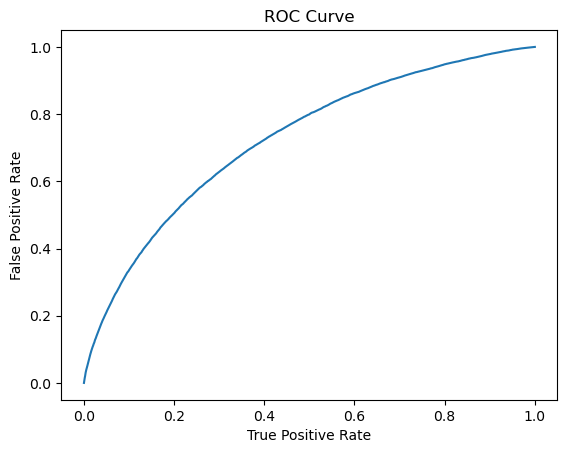

Training set ROC: 0.7240510891767478


In [24]:
#plotting the ROC Curve
trainingSummary = LR_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

In [25]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test SET ROC: " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))


Test SET ROC: 0.7172322264697136


In [26]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=15)
GBT_Model = gbt.fit(train)
gbt_predictions = GBT_Model.transform(test)
evaluator = BinaryClassificationEvaluator()

In [27]:
print("Test SET ROC: " + str(evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})))

Test SET ROC: 0.7296007667801193


In [28]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator  # Or your chosen evaluator
from pyspark.ml.classification import GBTClassifier  # Or your chosen model

# Assuming gbt and evaluator are defined. For example,
gbt = GBTClassifier(featuresCol="features", labelCol="label")
evaluator = BinaryClassificationEvaluator()

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20])
             .addGrid(gbt.maxIter, [10])
             .build())

cv = CrossValidator(estimator=gbt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

# Assuming 'train' and 'test' datasets are defined.
cvModel = cv.fit(train)
gbt_cv_predictions = cvModel.transform(test)
result = evaluator.evaluate(gbt_cv_predictions)

print("Evaluation metric:", result)


Evaluation metric: 0.7309844235657252
